In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sys
sys.path.insert(0,'src/')
import acs5
import nyserda_acs
import prices
import project_sunroof
import nyserda
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import Imputer
from sklearn.metrics import recall_score




%matplotlib inline

In [2]:
raw_data = nyserda_acs.merging_data()
raw_data=raw_data[raw_data['households']>0]

In [3]:
raw_data.shape

(4831, 157)

## Weights

In [4]:
#Duplicate positive rows
duplic = raw_data.loc[raw_data['Project_yes']==1,:]
duplic.loc[:,'Project_yes'] =0
duplic.loc[:,'Duplicate'] = 'Yes'
duplic.loc[:,'weight'] = (duplic.loc[:,'households']-duplic.loc[:,'Project_Number'])
duplic=duplic[duplic['weight']>0]
#Creating weights in old data
raw_data.loc[raw_data['Project_yes'] == 1, 'weight'] = raw_data['Project_Number']
raw_data.loc[raw_data['Project_yes'] == 0, 'weight'] = raw_data['households']
raw_data['Duplicate']='No'
#Merging data 
#Concatenating
all_data = raw_data.append(duplic, ignore_index=True)

/Users/mariamendieta/anaconda2/lib/python2.7/site-packages/pandas/core/indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/Users/mariamendieta/anaconda2/lib/python2.7/site-packages/pandas/core/indexing.py:337: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)


In [5]:
all_data.shape

(6022, 159)

In [6]:
raw_data['households'].sum(axis=None, skipna=True, level=None, numeric_only=None)

7262279L

In [7]:
raw_data['Project_Number'].sum(axis=None, skipna=True, level=None, numeric_only=None)/raw_data['households'].sum(axis=None, skipna=True, level=None, numeric_only=None)

0.010750482045649858

## Columns

In [8]:
acs_percent_variables = ['Percent_Less_9th','Percent_more_than_hs', 'Percent_1_unit','Avg_hh_size',
                'Percent_hh_w_children', 'Percent_10+_units', 'Percent_Heating_electricity',
                'yearly_sunlight_kwh_total'  , 'Percent_6_rooms', 'percent_qualified',
                'Project_yes','weight','Duplicate']

## Simple model

In [9]:
df=raw_data[acs_percent_variables]
df.describe()

,Percent_Less_9th,Percent_more_than_hs,Percent_1_unit,Avg_hh_size,Percent_hh_w_children,Percent_10+_units,Percent_Heating_electricity,yearly_sunlight_kwh_total,Percent_6_rooms,percent_qualified,Project_yes,weight
count,4831.000000,4831.000000,4831.000000,4825.000000,4831.000000,4831.000000,4831.000000,3.739000e+03,4831.000000,3739.000000,4831.000000,4831.000000
mean,0.067086,0.576501,0.482588,2.713188,0.286205,0.230209,0.095650,9.249323e+06,0.157265,74.146273,0.247154,1106.759677
std,0.066355,0.164563,0.333066,0.554915,0.100208,0.302982,0.100251,1.175220e+07,0.090244,13.161878,0.431402,904.993411
min,0.000000,0.000000,0.000000,1.030000,0.000000,0.000000,0.000000,2.178341e+03,0.000000,21.212121,0.000000,1.000000
25%,0.020387,0.458327,0.132480,2.350000,0.226397,0.011958,0.033696,2.905493e+06,0.084387,66.218202,0.000000,298.500000
50%,0.043080,0.570190,0.522355,2.640000,0.283035,0.077684,0.065364,4.895547e+06,0.158165,75.939850,0.000000,1065.000000
75%,0.094349,0.686537,0.784092,3.030000,0.346515,0.343447,0.120509,1.175304e+07,0.218540,83.643871,0.000000,1621.000000
max,0.445956,1.000000,1.000000,6.270000,1.000000,1.000000,1.000000,1.720241e+08,1.000000,100.000000,1.000000,8674.000000


In [10]:
df.shape

(4831, 13)

In [11]:
# Imputing missing values
df.loc[df['yearly_sunlight_kwh_total'].isnull(), 'yearly_sunlight_kwh_total'] = 0
df.loc[df['percent_qualified'].isnull(), 'percent_qualified'] = 200
df.loc[df['Avg_hh_size'].isnull(), 'Avg_hh_size']=np.mean(df.Avg_hh_size)

In [12]:
df.describe()

,Percent_Less_9th,Percent_more_than_hs,Percent_1_unit,Avg_hh_size,Percent_hh_w_children,Percent_10+_units,Percent_Heating_electricity,yearly_sunlight_kwh_total,Percent_6_rooms,percent_qualified,Project_yes,weight
count,4831.000000,4831.000000,4831.000000,4831.000000,4831.000000,4831.000000,4831.000000,4.831000e+03,4831.000000,4831.000000,4831.000000,4831.000000
mean,0.067086,0.576501,0.482588,2.713188,0.286205,0.230209,0.095650,7.158605e+06,0.157265,102.594269,0.247154,1106.759677
std,0.066355,0.164563,0.333066,0.554570,0.100208,0.302982,0.100251,1.103894e+07,0.090244,53.903993,0.431402,904.993411
min,0.000000,0.000000,0.000000,1.030000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,21.212121,0.000000,1.000000
25%,0.020387,0.458327,0.132480,2.350000,0.226397,0.011958,0.033696,9.854517e+05,0.084387,69.403086,0.000000,298.500000
50%,0.043080,0.570190,0.522355,2.640000,0.283035,0.077684,0.065364,3.585665e+06,0.158165,80.549683,0.000000,1065.000000
75%,0.094349,0.686537,0.784092,3.030000,0.346515,0.343447,0.120509,8.907324e+06,0.218540,94.555336,0.000000,1621.000000
max,0.445956,1.000000,1.000000,6.270000,1.000000,1.000000,1.000000,1.720241e+08,1.000000,200.000000,1.000000,8674.000000


In [13]:
y=df['Project_yes']
weights=df['weight']
features=df.drop(['Project_yes', 'weight','Duplicate'], axis=1)


In [14]:
features.shape

(4831, 10)

## My score - AUC

In [15]:
from sklearn.metrics import make_scorer
from sklearn.metrics import roc_curve, auc

# define scoring function 
def custom_auc(ground_truth, predictions):
    # I need only one column of predictions["0" and "1"]. You can get an error here
    # while trying to return both columns at once
    fpr, tpr, _ = roc_curve(ground_truth, predictions[:, 1], pos_label=1)    
    return auc(fpr, tpr)

# to be standart sklearn's scorer        
my_auc = make_scorer(custom_auc, greater_is_better=True, needs_proba=True)

In [16]:
X_train, X_test, y_train, y_test, weights_train, weights_test = train_test_split(features, y, weights, test_size=0.3, random_state=42)

In [17]:
model = GradientBoostingClassifier()
search = GridSearchCV(model, param_grid = {'n_estimators' : [500, 1000], 'subsample' :[0.5,0.8],
                                           'max_depth': [2,3,4,5], 'learning_rate' : [0.01, 0.001]}, 
                      scoring=my_auc, fit_params={'sample_weight': weights_train}, n_jobs=1, iid=True, refit=True, 
             cv=None, verbose=5, pre_dispatch='2*n_jobs', error_score='raise', return_train_score=True)

In [18]:
fitted = search.fit(X_train,y_train)

Fitting 3 folds for each of 32 candidates, totalling 96 fits
[CV] n_estimators=500, subsample=0.5, learning_rate=0.01, max_depth=2 
[CV]  n_estimators=500, subsample=0.5, learning_rate=0.01, max_depth=2, score=0.760543, total=   1.1s
[CV] n_estimators=500, subsample=0.5, learning_rate=0.01, max_depth=2 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.1s remaining:    0.0s


[CV]  n_estimators=500, subsample=0.5, learning_rate=0.01, max_depth=2, score=0.765707, total=   1.4s
[CV] n_estimators=500, subsample=0.5, learning_rate=0.01, max_depth=2 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    2.5s remaining:    0.0s


[CV]  n_estimators=500, subsample=0.5, learning_rate=0.01, max_depth=2, score=0.745753, total=   1.0s
[CV] n_estimators=500, subsample=0.8, learning_rate=0.01, max_depth=2 


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    3.5s remaining:    0.0s


[CV]  n_estimators=500, subsample=0.8, learning_rate=0.01, max_depth=2, score=0.764566, total=   1.1s
[CV] n_estimators=500, subsample=0.8, learning_rate=0.01, max_depth=2 


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    4.6s remaining:    0.0s


[CV]  n_estimators=500, subsample=0.8, learning_rate=0.01, max_depth=2, score=0.755241, total=   1.1s
[CV] n_estimators=500, subsample=0.8, learning_rate=0.01, max_depth=2 
[CV]  n_estimators=500, subsample=0.8, learning_rate=0.01, max_depth=2, score=0.751710, total=   1.7s
[CV] n_estimators=1000, subsample=0.5, learning_rate=0.01, max_depth=2 
[CV]  n_estimators=1000, subsample=0.5, learning_rate=0.01, max_depth=2, score=0.759635, total=   1.9s
[CV] n_estimators=1000, subsample=0.5, learning_rate=0.01, max_depth=2 
[CV]  n_estimators=1000, subsample=0.5, learning_rate=0.01, max_depth=2, score=0.749058, total=   2.0s
[CV] n_estimators=1000, subsample=0.5, learning_rate=0.01, max_depth=2 
[CV]  n_estimators=1000, subsample=0.5, learning_rate=0.01, max_depth=2, score=0.743940, total=   2.1s
[CV] n_estimators=1000, subsample=0.8, learning_rate=0.01, max_depth=2 
[CV]  n_estimators=1000, subsample=0.8, learning_rate=0.01, max_depth=2, score=0.758558, total=   2.5s
[CV] n_estimators=1000, s

[CV]  n_estimators=500, subsample=0.8, learning_rate=0.001, max_depth=2, score=0.745354, total=   1.0s
[CV] n_estimators=500, subsample=0.8, learning_rate=0.001, max_depth=2 
[CV]  n_estimators=500, subsample=0.8, learning_rate=0.001, max_depth=2, score=0.729217, total=   1.1s
[CV] n_estimators=1000, subsample=0.5, learning_rate=0.001, max_depth=2 
[CV]  n_estimators=1000, subsample=0.5, learning_rate=0.001, max_depth=2, score=0.751438, total=   1.9s
[CV] n_estimators=1000, subsample=0.5, learning_rate=0.001, max_depth=2 
[CV]  n_estimators=1000, subsample=0.5, learning_rate=0.001, max_depth=2, score=0.742773, total=   1.9s
[CV] n_estimators=1000, subsample=0.5, learning_rate=0.001, max_depth=2 
[CV]  n_estimators=1000, subsample=0.5, learning_rate=0.001, max_depth=2, score=0.738581, total=   1.9s
[CV] n_estimators=1000, subsample=0.8, learning_rate=0.001, max_depth=2 
[CV]  n_estimators=1000, subsample=0.8, learning_rate=0.001, max_depth=2, score=0.755077, total=   2.1s
[CV] n_estimat

[Parallel(n_jobs=1)]: Done  96 out of  96 | elapsed:  4.2min finished


In [19]:
fitted.score(X_test, y_test)

0.74734796737870512

In [20]:
recall_score(y_test, fitted.predict(X_test))

0.0

In [21]:
fitted.best_params_

{'learning_rate': 0.01, 'max_depth': 2, 'n_estimators': 500, 'subsample': 0.5}

In [22]:
# Adding results to orginal Data Frames
df['result']=fitted.predict_proba(features)[:,1]

/Users/mariamendieta/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [23]:
np.mean(df['result'])

0.023395895263356715

## ROC Curve

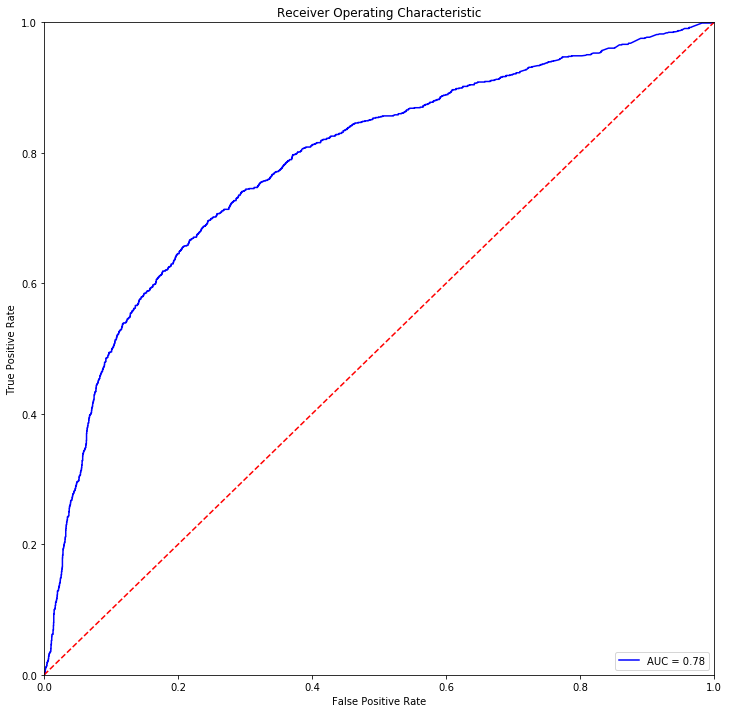

In [24]:
from sklearn import metrics
# calculate the fpr and tpr for all thresholds of the classification
probs = fitted.predict_proba(features)[:,1]
fpr, tpr, threshold = metrics.roc_curve(y, probs)
roc_auc = metrics.auc(fpr, tpr)

# method I: plt
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(12,12))
ax.set_title('Receiver Operating Characteristic')
ax.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
ax.legend(loc = 'lower right')
ax.plot([0, 1], [0, 1],'r--')
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])
ax.set_ylabel('True Positive Rate')
ax.set_xlabel('False Positive Rate')
fig.savefig('roc_sep8.png')
plt.show()


## Feature importance

In [25]:
model = GradientBoostingClassifier(learning_rate=0.01, max_depth=2, n_estimators=500, subsample=0.8)

In [26]:
fitted = model.fit(features, y, sample_weight=weights)

In [27]:
fitted.feature_importances_

array([ 0.10556025,  0.06115022,  0.26346775,  0.0178069 ,  0.01368011,
        0.13934557,  0.04637034,  0.16320717,  0.16470415,  0.02470755])

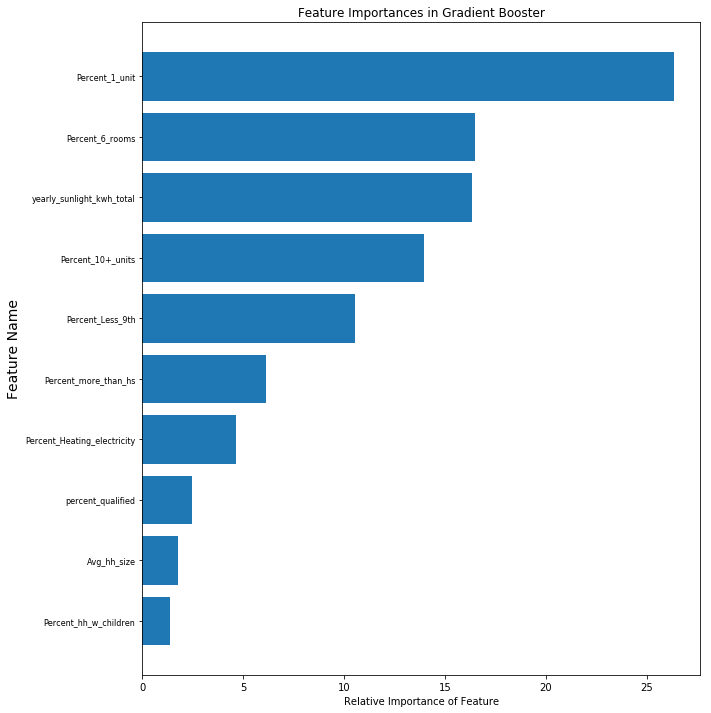

In [28]:
fitted.feature_importances_
feature_importances = 100*fitted.feature_importances_ / np.sum(fitted.feature_importances_)
feature_importances, feature_names, feature_idxs = zip(*sorted(zip(feature_importances, list(features.columns), range(len(features.columns)))))

width = 0.8

idx = np.arange(len(features.columns))

fig, ax = plt.subplots(figsize=(10,12))
ax.barh(idx, feature_importances, align='center')
plt.yticks(idx, feature_names, fontsize=8)

ax.set_title("Feature Importances in Gradient Booster")
ax.set_xlabel('Relative Importance of Feature', fontsize=10)
ax.set_ylabel('Feature Name', fontsize=14)
fig.savefig('feat_imp_sep8.png')

## Saving data with results

In [29]:
result = fitted.predict_proba(features)[:,1]
raw_data['result']=result
raw_data[raw_data['Project_yes']==0]
raw_data[raw_data['Project_yes']==0].to_csv('output_sep11.csv')

In [30]:
np.median(result)

0.012522743938285409